The idea with this script is that we want to use `convolve_test` to generate the merger data, then we want to be able to load that data here and make a large plot that has the all plot then the smaller populations underneath it

In [1]:
import os, copy, h5py
import astropy.units as u
from astropy.cosmology import Planck13, z_at_value
import numpy as np
import pandas as pd
from syntheticstellarpopconvolve import convolve, default_convolution_config, default_convolution_instruction
from syntheticstellarpopconvolve.general_functions import generate_boilerplate_outputfile, extract_unit_dict, temp_dir
from compas_python_utils.cosmic_integration.ClassCOMPAS import COMPASData
from syntheticstellarpopconvolve.starformation_rate_distributions import starformation_rate_distribution_vanSon2023, madau_dickinson_sfr
from syntheticstellarpopconvolve.metallicity_distributions import metallicity_distribution_vanSon2022, compas_log_skew_normal_distribution_metallicity_distribution
from syntheticstellarpopconvolve.general_functions import calculate_bincenters, calculate_bin_edges
from syntheticstellarpopconvolve.cosmology_utils import lookback_time_to_redshift
from syntheticstellarpopconvolve.SFR_dict_plotting_routines import plot_sfr_dict
import matplotlib.pyplot as plt
from population_vis import get_formation_efficiency
import time
import warnings
import scipy
from scipy import stats
from get_ZdepSFRD import skew_metallicity_distribution
import pickle

1 binary in COMPAS represents 79.11015055714887  solar masses formed
20000000
1582203011.1429775  [Msun]
ClassCOMPAS: Remember to self.setCOMPASDCOmask()
                    then self.setCOMPASData()
          and optionally self.setGridAndMassEvolved() if using a metallicity grid


/Users/alexandermigala/Documents/Github/metallicity_mergers/population_vis.py:143: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  eff_ax.legend()


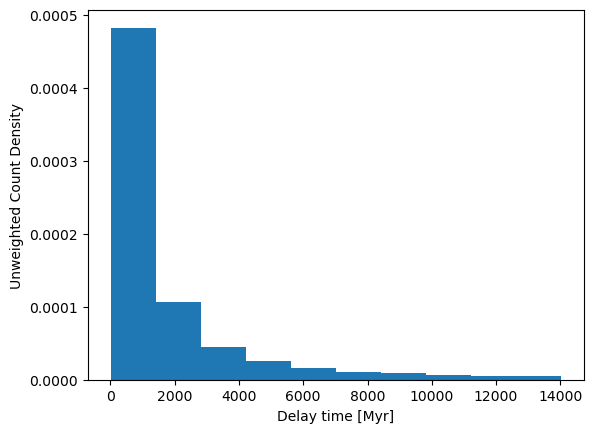

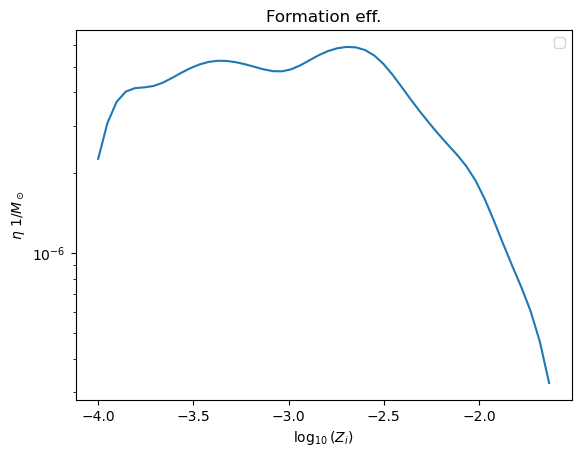

In [2]:
filepath = '/Volumes/Elements/Boesky_sims.h5'

# SET UP DATA -- from a basic dict, port to an h5 file and then store this into the output file
# now we want to use some real data
fdata = h5py.File(filepath)
all_dco_seeds = fdata['BSE_Double_Compact_Objects']['SEED'][()]
all_seeds = fdata['BSE_System_Parameters']['SEED'][()]
metallicities = fdata["BSE_System_Parameters"]["Metallicity@ZAMS(1)"][()]
fdata.close()
TYPES = 'BHNS'
fe_binned, fe_bins, compasdata = get_formation_efficiency(filepath, types=TYPES)
delayTimes = compasdata.delayTimes

# need to get the metallicities as well
dco_query = np.isin(all_seeds, all_dco_seeds[compasdata.DCOmask])
dco_metallicities = metallicities[dco_query]

Sum is 0.9993591035989038
Sum is 0.9995599462229728
Sum is 0.9996994245258342
Sum is 0.9997930621456227
Sum is 0.9998545081152381
Sum is 0.9997528790792566


/var/folders/xf/4xjcxwsx60s4g6c1mw4np0z40000gn/T/ipykernel_80640/1019117948.py:56: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  form_ax.set_ylim(1e-4,0)
/var/folders/xf/4xjcxwsx60s4g6c1mw4np0z40000gn/T/ipykernel_80640/1019117948.py:58: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  form_fig.show()


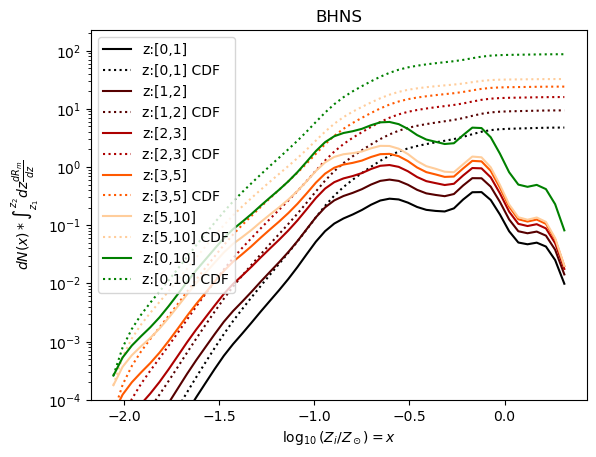

In [3]:
# basically same plot as above, but now we want to bin by redshift basically 
form_fig, form_ax = plt.subplots(1, 1)
PLOT_Z_LOG = True
Zm = np.log10(dco_metallicities/0.012) if PLOT_Z_LOG else dco_metallicities/0.012

with open('test.pkl', 'rb') as p:
    fiducial_plotting_data = pickle.load(p)

all_weights = fiducial_plotting_data['all_weights']
redshifts = fiducial_plotting_data['redshifts']

# sum up to z
redshift_edges = np.array([0, 1, 2, 3, 5, 10])#np.linspace(0, 14, 5)#np.logspace(np.log10(0.001), np.log10(14), 5)
def do_metallicity_plot_to_redshift(left, right, color):
    w = np.sum(all_weights[:, (np.digitize(left, redshift_edges)-1):(np.digitize(right, redshift_edges)-1)], axis=1)
    dco_met_hist, dco_met_bins = np.histogram(
        Zm,
        weights=w,
        bins=50,
        density=True
    )
    # print(np.sum(dco_met_hist*np.diff(dco_met_bins)))

    dco_metallicity_weighted_kde = stats.gaussian_kde(
        Zm,
        weights=w # TODO: multiply weights by mixture weights?
    )

    dco_met_bins_midpoints = (dco_met_bins[:-1]+dco_met_bins[1:])/2
    dlogZ = np.diff(dco_met_bins)
    print(f'Sum is {dco_metallicity_weighted_kde(dco_met_bins_midpoints)@dlogZ}')
    plot_line = dco_metallicity_weighted_kde(dco_met_bins_midpoints)*dlogZ*np.sum(w)
    lab = f'z:[{left},{right}]'
    form_ax.plot(dco_met_bins_midpoints, plot_line, label=lab, color=color)
    # form_ax.fill_between(dco_met_bins_midpoints, plot_line, alpha=0.3)

    # cdf_ax = form_ax.twinx()
    form_ax.plot(dco_met_bins_midpoints, np.cumsum(plot_line), label=f'{lab} CDF', linestyle=':', color=color)
    # cdf_ax.tick_params(axis='y', labelcolor='red')
    # cdf_ax.set_yscale('log')
    # form_ax.axhline(plot_line.max())

color_bins = plt.cm.gist_heat(np.linspace(0, 0.9, len(redshift_edges)-1))

for i in range(len(redshift_edges)-1):
    do_metallicity_plot_to_redshift(redshift_edges[i], redshift_edges[i+1], color_bins[i])
do_metallicity_plot_to_redshift(0, 10, 'green')
form_ax.set_xlabel(r'$\log_{10}(Z_i/Z_\odot)=x$' if PLOT_Z_LOG else r'$Z_i/Z_\odot=x$')
# form_ax.set_xlabel(r'$\log_{10}(Z_i)$')
# form_ax.set_ylabel(r'$\frac{dN(x)}{d\log Z_i}*d\log Z_i=dN(x)~\frac{\text{merger density}}{\text{year}}$')
form_ax.set_ylabel(r'$dN(x)*\int_{z_1}^{z_2} dz \frac{dR_m}{dz}$')
# form_ax.set_ylabel(r'$N(x)$ Density CDF')
# form_ax.set_xscale('log')
form_ax.set_yscale('log')
form_ax.set_title(f'{TYPES}')
form_ax.set_ylim(1e-4,0)
form_ax.legend()
form_fig.show()